<a href="https://colab.research.google.com/github/InigoZalaya/Proyecto-IMH-Master-Digital-Manufacturing/blob/main/Mantenimiento_Predictivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar máquina virtual para la ejecución en código python


In [36]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2303392648577884506
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 700385056990039248
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [37]:
!cat /proc/meminfo

MemTotal:       13302920 kB
MemFree:         7757704 kB
MemAvailable:   11718240 kB
Buffers:          130460 kB
Cached:          3049304 kB
SwapCached:            0 kB
Active:          1658208 kB
Inactive:        3548516 kB
Active(anon):    1057448 kB
Inactive(anon):     6624 kB
Active(file):     600760 kB
Inactive(file):  3541892 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               280 kB
Writeback:             0 kB
AnonPages:       2026900 kB
Mapped:           806308 kB
Shmem:              7340 kB
KReclaimable:     118720 kB
Slab:             173804 kB
SReclaimable:     118720 kB
SUnreclaim:        55084 kB
KernelStack:        5120 kB
PageTables:        13656 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651460 kB
Committed_AS:    5008152 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       46812 kB
VmallocChunk:          0 kB
Percpu:          

In [38]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

# Importar datasets Test, Train, Truth
Aquí se importan los archivos con los datos del uso de los motores, obtenidos por la NASA

In [39]:
!wget -q "https://drive.google.com/uc?export=download&id=1fckCOtn_BrfBiK5SJnzBUc3HeHA07Vk3" -O PM_test.txt 
!wget -q "https://drive.google.com/uc?export=download&id=1WzESa0n-7m_4ARF9_qKF5c1xEn4gkA72" -O PM_train.txt  
!wget -q "https://drive.google.com/uc?export=download&id=1f3w0K9Rvuyuh0og14CsfVUx0eHMYvp4D" -O PM_truth.txt


In [40]:
!ls

 binary_model.h5	       Model_regresión_verificación.png
 binary_submit_test.csv        Pérdida_modelo.png
 binary_submit_train.csv       PM_test.txt
'Curva Exactitud-Recall.png'   PM_train.txt
'Curva Roc.png'		       PM_truth.txt
 Exactitud_modelo.png	       regression_model.h5
 Model_MAE.png		       sample_data
 Modelo_R2.png		       submit_test.csv
 Modelo_verificación.png       submit_train.csv
 Model_regresión_pérdida.png


# Clasificación binaria, predecir el fallo del dispositivo
Predecir si el activo fallará en un plazo de tiempo, (p. ej. ciclos)

In [41]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# La "semilla" es un punto de partida para la secuencia y empezar desde la misma semilla garantiza la misma secuencia de números. 
# También se pueden realizar pruebas con diferentes valores de semillas.


# NumPy random seed es una función que establece la semilla aleatoria del generador de números pseudo-aleatorios de NumPy. Proporciona una entrada esencial que permite a NumPy generar números pseudoaleatorios para procesos aleatorios.

np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

# Definición de la ruta
model_path = 'binary_model.h5'


## Ingesta de datos
Añadir atributos a las columnas, así como, el id, los ciclos, las características de dieño, o los sensores

In [42]:
# Lectura datos de entrenamiento modelo - Son los datos de funcionamiento del motor hasta el fallo
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# Lectura datos de los tests - Son los datos de funcionamiento del motor sin que se registren eventos de fallo
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# Lectura datos restantes - Es la información de los ciclos reales restantes para cada motor en los datos de prueba
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


## Procesamiento de datos

In [43]:
#######
# Entrenamiento
#######

# Data labeling - generar una columna RUL (Remaining Usefull Life) o tiempo hasta el fallo
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# Generar etiquetas para entrenar los datos
# Se usará "label1" para clasificación binaria, y responder a la pregunta: ¿fallará un motor dentro de los ciclos w1?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# Normalización MinMax (desde 0 hasta 1). Transformar los atributos escalando cada una a un rango determinado
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

######
# TEST
######
# Normalización MinMax (desde 0 hasta 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)


# Se usa el conjunto de datos "truth" para generar etiquetas para los datos de prueba.
# Generar la columna Max para el dataset Test
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# Generar RUL para los datos de prueba
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generar las columnas w0 y w1 para los datos de prueba
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2


## Red Neuronal Long-Short-Term-Memory

In [44]:
# Elegir una ventana grande de 50 ciclos
sequence_length = 50

# Función para remodelar las características en (muestras, time steps, características) 
def gen_sequence(id_df, seq_length, seq_cols):
    """Sólo se consideran las secuencias que cumplen con la longitud de la ventana, no se utiliza ningún relleno. 
    Esto significa que para las pruebas tenemos que descartar las que están por debajo de la longitud de la ventana. 
    Una alternativa sería rellenar las secuencias para que podamos utilizar una más cortas"""
    
    # Para cada Id, se introducen todas las filas en una matriz
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    # Iterar sobre dos listas en paralelo
    # Por ejemplo, id1 tiene 192 líneas y sequence_length es igual a 50
    # iterar sobre las dos siguientes listas de números (0,112),(50,192)
    # 0 50 -> desde la fila 0 hasta la 50
    # 1 51 -> desde la fila 1 hasta la 51
    # 2 52 -> desde la fila 2 hasta la 52
    # ...
    # 111 191 -> desde 111 hasta la 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# Seleccionar la columna de características
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# Crear una generación para las secuencias
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# Generar sequencias y convertir a Numpy Array (datos del mismo tipo)
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# Crear función para generación de etiquetas
def gen_labels(id_df, seq_length, label):
    # Para cada Id, se introducen todas las etiquetas en una matriz
    # Por ejemplo:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

# Generar etiquetas
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


"""A continuación, se crea una red neuronal""" 

# La primera capa es una LSTM, con 100 unidades seguidas por otra capa LSTM con 50 unidades. 
# Se aplica la técnica dropout de regularización, después de cada capa LSTM para controlar el sobreajuste. 
# La capa final, es la capa de salida Dense, y una función de activación sigmoide para la clasificación binaria.


# Contrucción de la red
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Ajustar la red
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# Registrar y visualizar todos los datos
print(history.history.keys())



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50, 100)           50400     
                                                                 
 dropout_8 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
75/75 - 7s - loss: 0.2540 - accur

## Evaluación del modelo, dataset Test

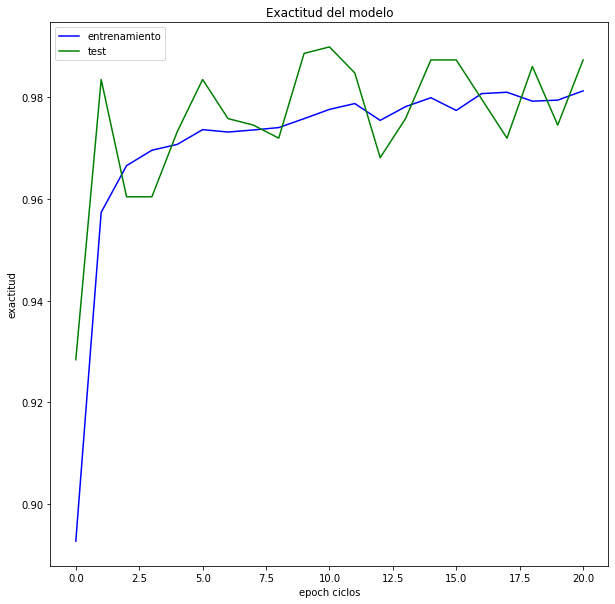

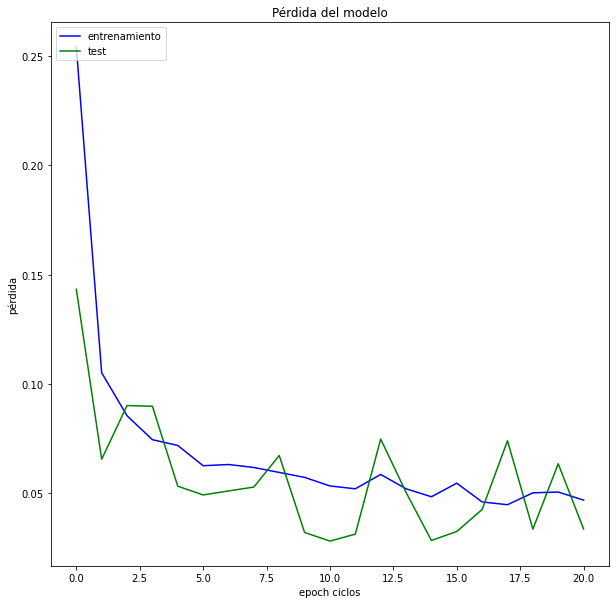



79/79 [==============================] - 2s 11ms/step


Matriz de confusión
- eje-x son los valores reales.
- eje-y son los valores predichos


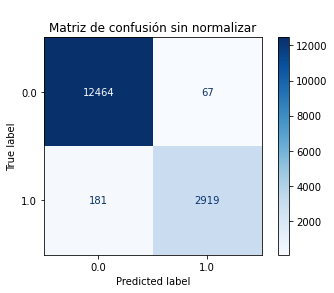

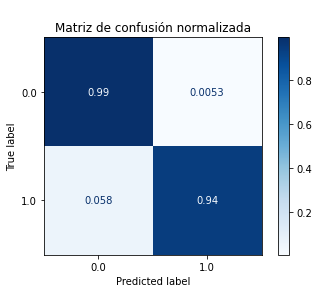


Exactitud =  0.977561955793704 
 Sensibilidad =  0.9416129032258065


Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     12531
         1.0       0.98      0.94      0.96      3100

    accuracy                           0.98     15631
   macro avg       0.98      0.97      0.97     15631
weighted avg       0.98      0.98      0.98     15631





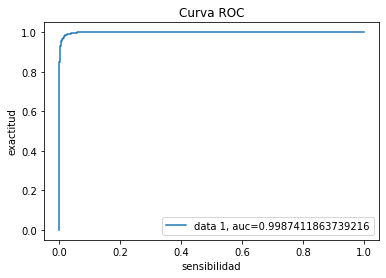

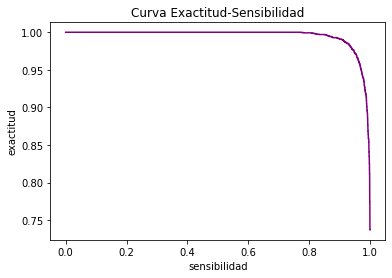

In [45]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
 

import matplotlib.pyplot as plt


# Filtrar los datos para crear la gráfica de la Exactitud
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], color="blue")
plt.plot(history.history['val_accuracy'], color="green")
plt.title('Exactitud del modelo')
plt.ylabel('exactitud')
plt.xlabel('epoch ciclos')
plt.legend(['entrenamiento', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("Exactitud_modelo.png")

print('\n')

# Filtrar los datos para crear la gráfica de la Pérdida
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], color="blue")
plt.plot(history.history['val_loss'], color="green")
plt.title('Pérdida del modelo')
plt.ylabel('pérdida')
plt.xlabel('epoch ciclos')
plt.legend(['entrenamiento', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("Pérdida_modelo.png")

print('\n')
# Entrenar las métricas para la matriz
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
#print('\nExactitud: {}'.format(scores[1]))

# Hacer las predicciones y calcular la matriz de confusión
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

#predict_x=model.predict(X_test) 
#classes_x=np.argmax(predict_x,axis=1)

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)


print('\n\nMatriz de confusión\n- eje-x son los valores reales.\n- eje-y son los valores predichos')
cm = confusion_matrix(y_true, y_pred.round())
#print(cm)
#plt.show()


# Gráfica matriz de confusión no-normalizada
titles_options = [
    ("\nMatriz de confusión sin normalizar", None),
    ("\nMatriz de confusión normalizada", "true"),
]

#classifier = svm.SVC(kernel="linear", C=0.01).fit(y_true, y_pred.round())

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        
        y_true,
        y_pred.round(),
         cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()



# Calcular la precisión y el recall
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
print( '\nExactitud = ', precision, '\n', 'Sensibilidad = ', recall)



# Gráfica informe de clasificación
from sklearn.metrics import classification_report, plot_roc_curve, roc_curve, roc_auc_score
print('\n\nInforme de clasificación:')
print(classification_report(y_true, y_pred.round()))


# Gráfica de resultados
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
#print(precision)
#print(recall)
#print(thresholds)

print('\n')

# Gráfica curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred)

auc = roc_auc_score(y_true, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Curva ROC')
plt.ylabel('exactitud')
plt.xlabel('sensibilidad')
plt.show()


print('\n')

# Gráfica curva Precisión-Recall
# Crear la curva Precisión-Recall
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Curva Exactitud-Sensibilidad')
ax.set_ylabel('exactitud')
ax.set_xlabel('sensibilidad')
plt.show()



## Evaluación del modelo, dataset Validación

3/3 - 1s - loss: 0.0410 - accuracy: 0.9785 - 958ms/epoch - 319ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


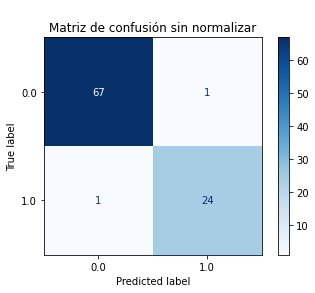

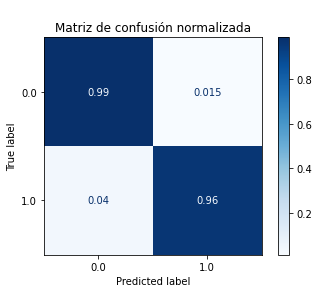


Exactitud:  0.96 
 Sensibilidad:  0.96 
 F1-score: 0.96


Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        68
         1.0       0.96      0.96      0.96        25

    accuracy                           0.98        93
   macro avg       0.97      0.97      0.97        93
weighted avg       0.98      0.98      0.98        93





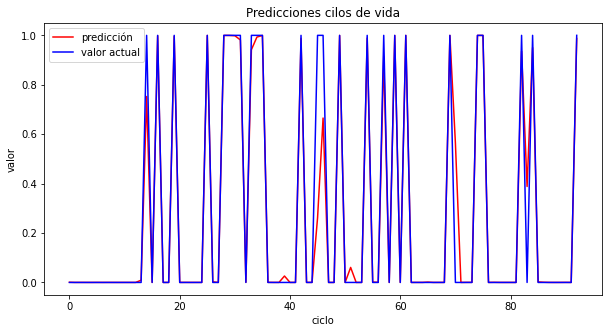

In [46]:
# Elegir la última secuencia de cada id en los datos de prueba

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)


# De forma similar, escoger las etiquetas
# print("y_mask")
# se utiliza para tomar sólo las etiquetas de las secuencias que tienen una longitud mínima del 50%.
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
#print("y_mask")
#print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)


# si el modelo de la mejor iteración fue guardado, cargarlo y usarlo
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
#print('Accurracy: {}'.format(scores_test[1]))

# Hacer las predicciones y calcular la matriz de confusión
y_pred_test = estimator.predict(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test.round())
#print(cm)


# Gráfica matriz de confusión no-normalizada
titles_options = [
    ("\nMatriz de confusión sin normalizar", None),
    ("\nMatriz de confusión normalizada", "true"),
]

#classifier = svm.SVC(kernel="linear", C=0.01).fit(y_true, y_pred.round())

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        
        y_true_test,
        y_pred_test.round(),
         cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()


# Calcular precisión y recall
precision_test = precision_score(y_true_test, y_pred_test.round())
recall_test = recall_score(y_true_test, y_pred_test.round())
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( '\nExactitud: ', precision_test, '\n', 'Sensibilidad: ', recall_test,'\n', 'F1-score:', f1_test )


# Gráfica informe de clasificación
from sklearn.metrics import classification_report, plot_roc_curve, roc_curve, roc_auc_score
print('\n\nInforme de clasificación:')
print(classification_report(y_true_test, y_pred_test.round()))


# Gráfica de resultados
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
#print(precision)
#print(recall)
#print(thresholds)

print('\n')

# Representar en color azul los datos predichos y en color verde los datos reales 
# para verificar visualmente la precisión del modelo
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="red")
plt.plot(y_true_test, color="blue")
plt.title('Predicciones cilos de vida')
plt.ylabel('valor')
plt.xlabel('ciclo')
plt.legend(['predicción', 'valor actual'], loc='upper left')
plt.show()
fig_verify.savefig("Modelo_verificación.png")


# Regresión, Vida útil restante (RUL)
¿Cuántos ciclos más durará un motor en servicio antes de fallar?

In [47]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Configurar la semilla para reproducibilidad
np.random.seed(1234)  
PYTHONHASHSEED = 0

# Definición de la ruta para guardar el modelo
model_path = 'regression_model.h5'


## Ingesta de datos

In [48]:
# Lectura datos de entrenamiento modelo - Son los datos de funcionamiento del motor hasta el fallo
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# Lectura datos de los tests - Son los datos de funcionamiento del motor sin que se registren eventos de fallo
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# Lectura datos restantes - Es la información de los ciclos reales restantes para cada motor en los datos de prueba
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


## Procesamiento de datos

In [49]:
#######
# Entrenamiento
#######

# Data labeling - generar una columna RUL (Remaining Usefull Life) o tiempo hasta el fallo
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# Generar etiquetas para entrenar los datos
# Se usará "label1" para clasificación binaria, y responder a la pregunta: ¿fallará un motor dentro de los ciclos w1?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# Normalización MinMax (desde 0 hasta 1). Transformar los atributos escalando cada una a un rango determinado
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)

######
# TEST
######
# Normalización MinMax (desde 0 hasta 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# Se usa el conjunto de datos "truth" para generar etiquetas para los datos de prueba.
# Generar la columna Max para el dataset Test
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# Generar RUL para los datos de prueba
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generar las columnas w0 y w1 para los datos de prueba
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

# Elegir una ventana grande de 50 ciclos
sequence_length = 50

# Función para remodelar las características en (muestras, time steps, características)  
def gen_sequence(id_df, seq_length, seq_cols):
    """Sólo se consideran las secuencias que cumplen con la longitud de la ventana, no se utiliza ningún relleno. 
    Esto significa que para las pruebas tenemos que descartar las que están por debajo de la longitud de la ventana. 
    Una alternativa sería rellenar las secuencias para que podamos utilizar una más cortas"""

    # Para cada Id, se introducen todas las filas en una matriz
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    # Iterar sobre dos listas en paralelo
    # Por ejemplo, id1 tiene 192 líneas y sequence_length es igual a 50
    # iterar sobre las dos siguientes listas de números (0,112),(50,192)
    # 0 50 -> desde la fila 0 hasta la 50
    # 1 51 -> desde la fila 1 hasta la 51
    # 2 52 -> desde la fila 2 hasta la 52
    # ...
    # 111 191 -> desde 111 hasta la 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# Seleccionar la columna de características 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

 
# val es una lista de 192-50=142 arrays bi-dimensionales (50 filas x 25 columnas)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# Generador para secuencias
# Transformar cada id del dataset "train" en una sequencia
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# Generar sequencias y convertir a Numpy Array (datos del mismo tipo)
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# Crear función para generación de etiquetas
def gen_labels(id_df, seq_length, label):
    """  """
    # Para cada Id, se introducen todas las etiquetas en una matriz
    # Por ejemplo:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]  

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

# Generar etiquetas
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array


   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]
142
(15631, 50, 25)


array([[141.],
       [140.],
       [139.],
       ...,
       [  2.],
       [  1.],
       [  0.]], dtype=float32)

## Red Neuronal Long-Short-Term-Memory

In [50]:
def r2_keras(y_true, y_pred):
    """Coeficiente de determinación"""

    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# La primera capa es una LSTM, con 100 unidades seguidas por otra capa LSTM con 50 unidades. 
# Se aplica la técnica dropout de regularización, después de cada capa LSTM para controlar el sobreajuste. 
# La capa final, es la capa de salida Dense, y una función de activación Linear, al tratarse de un problema de regresión.


# Contrucción de la red
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# Ajustar la red
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# Registrar y visualizar todos los datos
print(history.history.keys())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50, 100)           50400     
                                                                 
 dropout_10 (Dropout)        (None, 50, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trai

## Evaluación del modelo, dataset Test

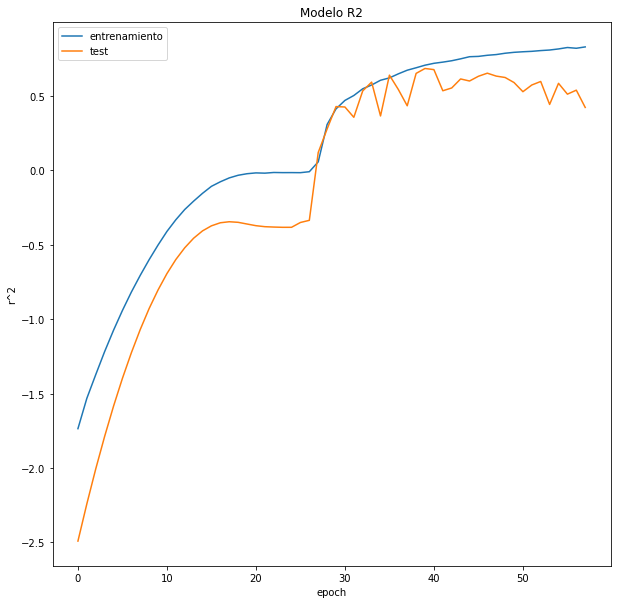

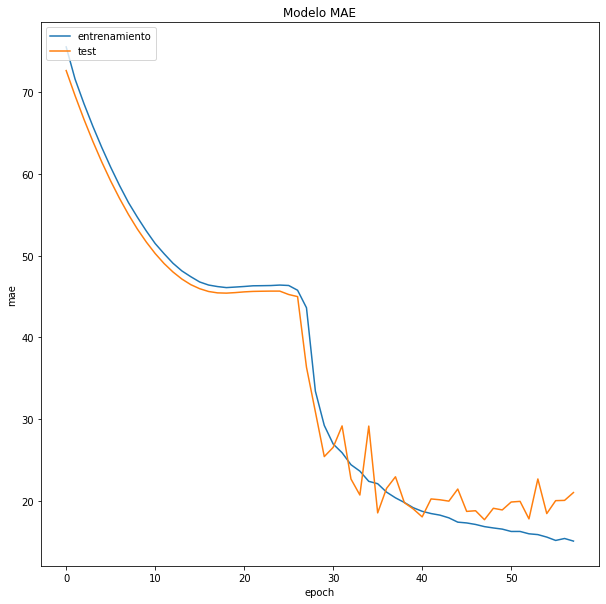

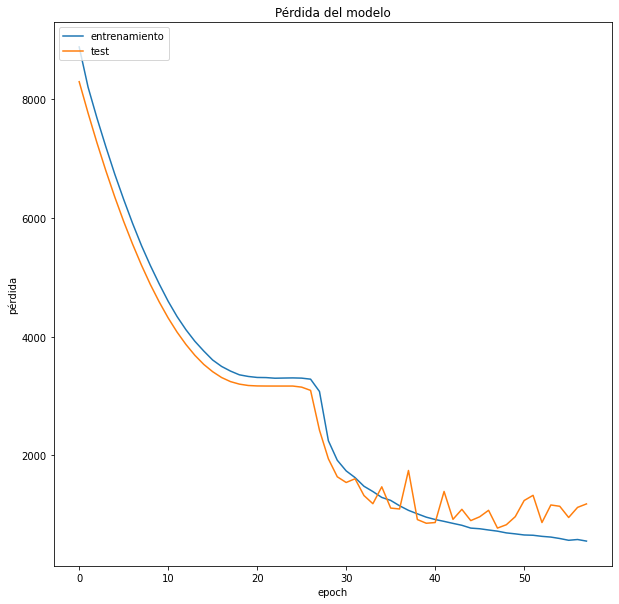

79/79 [==============================] - 1s 15ms/step - loss: 492.8141 - mae: 13.5393 - r2_keras: 0.8180

MAE: 13.539337158203125

R^2: 0.8180102705955505
79/79 [==============================] - 2s 10ms/step


In [51]:
# Filtrar los datos para crear la gráfica del coeficiente de determinación R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('Modelo R2')
plt.ylabel('r^2')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("Modelo_R2.png")

# Filtrar los datos para crear la gráfica MAE (Mean Absolute Error)
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Modelo MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("Model_MAE.png")

# Filtrar los datos para crear la gráfica de la Pérdida
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('pérdida')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("Model_regresión_pérdida.png")

# Entrenar las métricas para la matriz
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)


## Evaluación del modelo, dataset Validación

3/3 - 1s - loss: 399.7870 - mae: 13.6529 - r2_keras: 0.7511 - 976ms/epoch - 325ms/step

MAE: 13.65291976928711

R^2: 0.7510901093482971


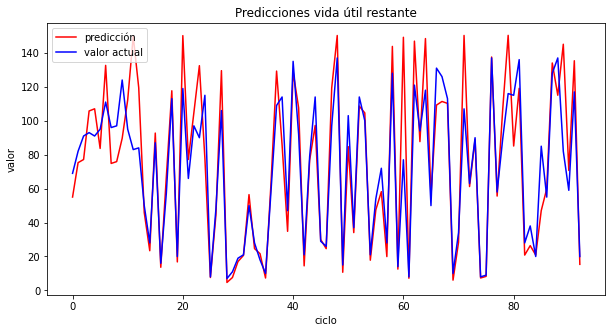

In [52]:
# Elegir la última secuencia de cada id en los datos de prueba

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)


# De forma similar, escoger las etiquetas
# print("y_mask")
# se utiliza para tomar sólo las etiquetas de las secuencias que tienen una longitud mínima del 50%.
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# si el modelo de la mejor iteración fue guardado, cargarlo y usarlo
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

# Hacer las predicciones y calcular la matriz de confusión
    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Representar en color azul los datos predichos y en color verde los datos reales 
    # para verificar visualmente la precisión del modelo
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="red")
    plt.plot(y_true_test, color="blue")
    plt.title('Predicciones vida útil restante')
    plt.ylabel('valor')
    plt.xlabel('ciclo')
    plt.legend(['predicción', 'valor actual'], loc='upper left')
    plt.show()
    fig_verify.savefig("Model_regresión_verificación.png")
    

# Bibliografía

- [1] Deep Learning Basics for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
- [2] Predictive Maintenance https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM
- [3] Predictive Maintenance Steps Template https://gallery.azure.ai/Collection/Predictive-Maintenance-Template-3
- [4] A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA 
- [5] Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- [6] Challenges of training a Neural Network https://machinelearningmastery.com/why-training-a-neural-network-is-hard/
- [7] Classification report https://muthu.co/understanding-the-classification-report-in-sklearn/
- [8] Verification of results https://medium.com/@ewuramaminka/mean-absolute-error-mae-machine-learning-ml-b9b4afc63077